<a href="https://colab.research.google.com/github/heber-augusto/sus-kpis-analysis/blob/main/notebooks/template_consultas_lake_rosa_google_drive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Configuração do ambiente e carregamento do catálogo

**Lembre-se de baixar o arquivo json que garante acesso ao google storage**
 - monitor-rosa-escrita.json: acesso para criação de tabelas;
 - monitor-rosa-leitura.json: acesso para analises e consultas.

## Escolha do ambiente
São disponibilizadas duas opções de execução (dependendo do arquivo de credencial utilizado)
 - gcp-leitura.json: disponível para analises e usuários que não possuem permissão de escrita;
 - gcp-escrita.json: disponível para atualização de bases (testes de desenvolvimento ou ambiente de produção).

In [1]:
import os
if os.path.isfile('/content/monitor-rosa-leitura.json'):
    datalake_mode = 'leitura'
elif os.path.isfile('/content/monitor-rosa-escrita.json'):
    datalake_mode = 'escrita'
else:
    assert(os.path.isdir('/content/drive/Shareddrives/Monitor Rosa/datalake') == True)
    datalake_mode = 'shared_drive'
datalake_mode

'shared_drive'

In [2]:
!rm -r sus-kpis-analysis
!git clone https://github.com/heber-augusto/sus-kpis-analysis.git

rm: cannot remove 'sus-kpis-analysis': No such file or directory
Cloning into 'sus-kpis-analysis'...
remote: Enumerating objects: 1093, done.
remote: Counting objects: 100% (454/454), done.
remote: Compressing objects: 100% (295/295), done.
remote: Total 1093 (delta 222), reused 280 (delta 139), pack-reused 639
Receiving objects: 100% (1093/1093), 2.97 MiB | 9.04 MiB/s, done.
Resolving deltas: 100% (539/539), done.


## Instalação de libs Python, inicialização de variáveis de ambiente e configuração/instalação do Spark

In [3]:
!pip install -r /content/sus-kpis-analysis/sia/etls/requirements.txt

%env PYTHONHASHSEED=1234
%env JAVA_HOME=/usr/lib/jvm/java-8-openjdk-amd64
%env SPARK_HOME=/content/spark-3.4.2-bin-hadoop3
%env SPARK_VERSION=3.4.2

!source /content/sus-kpis-analysis/sia/etls/bin/setup_spark_env.sh '/content/'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.1/311.1 MB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.2-py2.py3-none-any.whl size=311619832 sha256=dbf63d9ea623bea7a0800fbd2d2e20e271b957ac78d527b363a6617445e04490
  Stored in directory: /root/.cache/pip/wheels/0a/46/b6/5ca3debe11084c0ebb093d2809b6ae2844a6deebb11409a391
Successfully built pyspark
env: PYTHONHASHSEED=1234
env: JAVA_HOME=/usr/lib/jvm/java-8-openjdk-amd64
env: SPARK_HOME=/content/spark-3.4.2-bin-hadoop3
env: SPARK_VERSION=3.4.2
starting spark env setup 
installing and downloading packages
setting enviroment variables


In [4]:
if datalake_mode != 'shared_drive':
    %env XDG_CONFIG_HOME=/content
    !fusermount -u /content/datalake
    !source /content/sus-kpis-analysis/sia/etls/bin/mount_google_drive.sh '/content' 'acesso-leitura@monitor-rosa.iam.gserviceaccount.com' '0ABIY-a4qrdY9Uk9PVA'

## Inicializa variáveis de acesso ao delta lake criado no google storage

- Local do arquivo de credencial do storage, diretorio do warehouse e path do spark:

> O arquivo json_file_name deve ser enviado para o ambiente e deve ser utilizado um com as devidas permissões (em caso de escrita)

> O caminho do warehouse pode ser alterado em caso de testes de escritas locais.

> O caminho do spark é setado pelo script de configuração

In [5]:
import os

# id do projeto
# project_id = 'teak-ellipse-317015'
# id do bucket dentro do projeto
# bucket_id = 'observatorio-oncologia'

# nome da pasta do projeto
project_folder_name = 'monitor'

lake_prefix = "lake-rosa-prd"

#lake_zone = "bronze"

database_name = "cancer_data"

if datalake_mode in ('leitura','shared_drive' ):
    warehouse_dir = f"/content/{lake_prefix}/"

if datalake_mode == 'escrita':
    warehouse_dir = f"/content/datalake/datalake/{lake_prefix}/"

spark_path = os.getenv('SPARK_HOME')
spark_path

'/content/spark-3.4.2-bin-hadoop3'

## Inclusão da pasta do repositório no python path

Procedimento permite que funções e classes presentes no repositório sejam utilizadas

In [6]:
import sys
sys.path.append('/content/sus-kpis-analysis')
sys.path

['/content',
 '/env/python',
 '/usr/lib/python310.zip',
 '/usr/lib/python3.10',
 '/usr/lib/python3.10/lib-dynload',
 '',
 '/usr/local/lib/python3.10/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.10/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/sus-kpis-analysis']

## Importação de funções utilizadas pelo código

In [7]:
from sia.etls.lib.catalog_loader import DeltaLakeDatabaseFsCreator, load_entire_catalog_fs
from sia.etls.lib.table_utilities import vacuum_tables_from_database, table_exists
from sia.etls.lib.fs_spark_session import create_fs_spark_session
from sia.etls.lib.bronze_files_utilities import get_pending_files_from_bronze
from sia.etls.lib.delta_table_creators import ParquetToDelta

## Cria Sessão Spark conectada ao Delta Lake presente no Google Storage

In [8]:
spark = create_fs_spark_session(
    warehouse_dir=warehouse_dir,
    spark_path=spark_path
)


## Refresh do catálogo para utilizar consultas

In [ ]:
if datalake_mode in ('leitura', 'escrita'):
    gd_lake_prefix = f'/content/datalake/datalake/{lake_prefix}'
else:
    gd_lake_prefix = f'/content/drive/Shareddrives/Monitor Rosa/datalake/{lake_prefix}'

# carrega catalogo de banco de dados, na zona bronze
load_entire_catalog_fs(
    spark_session = spark,
    lake_prefix = gd_lake_prefix,
    use_db_folder_path=(datalake_mode == 'escrita'))

['sia_bronze.db', 'cnes_bronze.db', 'sim_bronze.db', 'sih_bronze.db']
Banco de dados sia_bronze criado.
listando conteúdos do caminho /content/drive/Shareddrives/Monitor Rosa/datalake/lake-rosa-prd/bronze e database sia_bronze
prefix: /content/drive/Shareddrives/Monitor Rosa/datalake/lake-rosa-prd/bronze/sia_bronze.db/
table_list: ['bi', 'ar', 'aq', 'am', 'pa']


# Exemplos de consultas

## Listagem de bancos e tabelas

In [18]:
databases = spark.sql(f"SHOW DATABASES;")
databases.show()

+-----------+
|  namespace|
+-----------+
|cancer_data|
|cnes_bronze|
|    default|
| sia_bronze|
| sih_bronze|
| sim_bronze|
+-----------+



In [19]:
for row in databases.collect():
    spark.sql(f"SHOW TABLES FROM {row['namespace']};").show(truncate=False)

+-----------+-------------------------+-----------+
|namespace  |tableName                |isTemporary|
+-----------+-------------------------+-----------+
|cancer_data|aq_filtered              |false      |
|cancer_data|ar_filtered              |false      |
|cancer_data|cadastro_municipios      |false      |
|cancer_data|dados_estados_mensal     |false      |
|cancer_data|dados_municipios_mensal  |false      |
|cancer_data|demografia_municipios    |false      |
|cancer_data|pacientes                |false      |
|cancer_data|procedimentos            |false      |
|cancer_data|procedimentos_e_pacientes|false      |
+-----------+-------------------------+-----------+

+-----------+---------+-----------+
|namespace  |tableName|isTemporary|
+-----------+---------+-----------+
|cnes_bronze|dc       |false      |
|cnes_bronze|ep       |false      |
|cnes_bronze|eq       |false      |
|cnes_bronze|hb       |false      |
|cnes_bronze|in       |false      |
|cnes_bronze|lt       |false      |

## Consultas em dados de Mortalidade (SIM:DORES)

In [15]:
spark.sql(f"""
    select count(*)
    from sim_bronze.dores
    where _filename like '%2020%'
""").show(truncate=False)

+--------+
|count(1)|
+--------+
|1556824 |
+--------+



In [23]:
spark.sql(f"""
    select to_date(DTOBITO,'ddMMyyyy') as dia,
           to_date(DTNASC,'ddMMyyyy') as data_nascimento,
          SEXO,
          RACACOR,
          CAUSABAS
    from sim_bronze.dores
    WHERE CAUSABAS like '%C50%'

""").show(truncate=False)

+----------+---------------+----+-------+--------+
|dia       |data_nascimento|SEXO|RACACOR|CAUSABAS|
+----------+---------------+----+-------+--------+
|2021-01-12|1954-01-02     |2   |2      |C509    |
|2021-01-27|1956-01-13     |2   |4      |C509    |
|2021-03-12|1956-04-18     |2   |1      |C508    |
|2021-05-15|1982-10-27     |2   |4      |C509    |
|2021-04-23|1944-08-25     |2   |1      |C509    |
|2021-05-14|1956-08-15     |2   |1      |C509    |
|2021-01-19|1950-12-18     |2   |1      |C509    |
|2021-02-28|1961-09-04     |2   |1      |C509    |
|2021-01-27|1967-09-15     |2   |4      |C509    |
|2021-02-25|1946-12-22     |2   |1      |C509    |
|2021-04-06|1973-04-24     |2   |1      |C509    |
|2021-01-18|1970-10-11     |2   |4      |C509    |
|2021-02-10|1959-01-25     |2   |1      |C509    |
|2021-02-03|1942-07-27     |2   |1      |C509    |
|2021-02-13|1946-10-28     |2   |1      |C509    |
|2021-02-05|1958-03-16     |2   |1      |C509    |
|2021-01-18|1983-07-08     |2  

In [24]:
df_sp = spark.sql(f"""
    select date_trunc('MONTH', to_date(DTOBITO,'ddMMyyyy')) as mes_obito,
           count(*) as quantidade
    from sim_bronze.dores
    WHERE CAUSABAS like '%C50%' AND _filename IN ('DOSP2014.parquet.gzip', 'DOSP2015.parquet.gzip')
    GROUP BY mes_obito
    ORDER BY mes_obito

""")

df_sp.show(truncate=False)

+-------------------+----------+
|mes_obito          |quantidade|
+-------------------+----------+
|2014-01-01 00:00:00|343       |
|2014-02-01 00:00:00|317       |
|2014-03-01 00:00:00|333       |
|2014-04-01 00:00:00|322       |
|2014-05-01 00:00:00|340       |
|2014-06-01 00:00:00|294       |
|2014-07-01 00:00:00|310       |
|2014-08-01 00:00:00|303       |
|2014-09-01 00:00:00|291       |
|2014-10-01 00:00:00|327       |
|2014-11-01 00:00:00|331       |
|2014-12-01 00:00:00|334       |
|2015-01-01 00:00:00|334       |
|2015-02-01 00:00:00|268       |
|2015-03-01 00:00:00|305       |
|2015-04-01 00:00:00|318       |
|2015-05-01 00:00:00|371       |
|2015-06-01 00:00:00|361       |
|2015-07-01 00:00:00|341       |
|2015-08-01 00:00:00|343       |
+-------------------+----------+
only showing top 20 rows



In [25]:
df_sp_pd = df_sp.toPandas()

/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


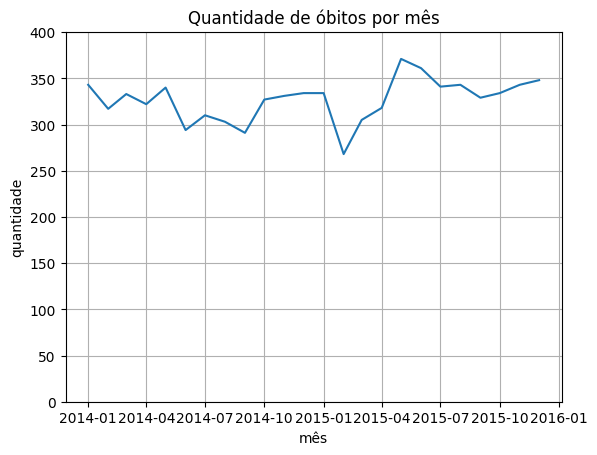

In [26]:
_ = """df_sp_pd.plot.line(
    x="mes_obito",
    y="quantidade")"""

import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
x = df_sp_pd['mes_obito']
y = df_sp_pd['quantidade']

fig, ax = plt.subplots()
ax.plot(x, y)

ax.set(
    xlabel='mês',
    ylabel='quantidade',
    title='Quantidade de óbitos por mês')
ax.grid()
ax.set_ylim([0, 400])
fig.savefig("test.png")
plt.show()


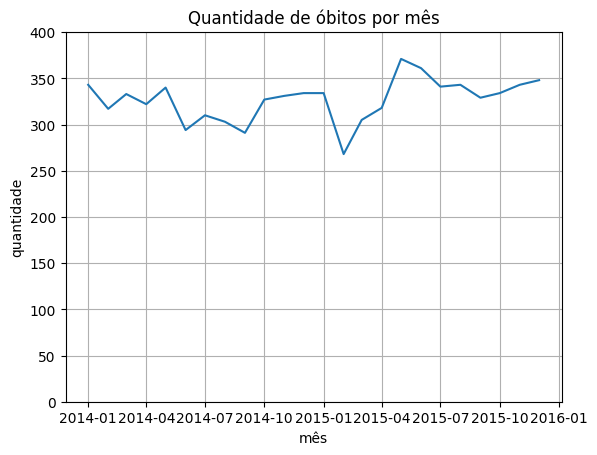

In [ ]:
_ = """df_sp_pd.plot.line(
    x="mes_obito",
    y="quantidade")"""

import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
x = df_sp_pd['mes_obito']
y = df_sp_pd['quantidade']

fig, ax = plt.subplots()
ax.plot(x, y)

ax.set(
    xlabel='mês',
    ylabel='quantidade',
    title='Quantidade de óbitos por mês')
ax.grid()
ax.set_ylim([0, 400])
fig.savefig("test.png")
plt.show()


## Consultas em dados de cidades

In [27]:
spark.sql(f"SELECT * FROM cancer_data.cadastro_municipios WHERE nome_uf = 'São Paulo'").show()

+-------+--------------------+-----+---------+
|     id|                nome|id_uf|  nome_uf|
+-------+--------------------+-----+---------+
|3500105|          Adamantina|   35|São Paulo|
|3500204|              Adolfo|   35|São Paulo|
|3500303|               Aguaí|   35|São Paulo|
|3500402|      Águas da Prata|   35|São Paulo|
|3500501|    Águas de Lindóia|   35|São Paulo|
|3500550|Águas de Santa Bá...|   35|São Paulo|
|3500600|  Águas de São Pedro|   35|São Paulo|
|3500709|              Agudos|   35|São Paulo|
|3500758|            Alambari|   35|São Paulo|
|3500808|   Alfredo Marcondes|   35|São Paulo|
|3500907|              Altair|   35|São Paulo|
|3501004|         Altinópolis|   35|São Paulo|
|3501103|         Alto Alegre|   35|São Paulo|
|3501152|            Alumínio|   35|São Paulo|
|3501202|    Álvares Florence|   35|São Paulo|
|3501301|     Álvares Machado|   35|São Paulo|
|3501400|  Álvaro de Carvalho|   35|São Paulo|
|3501509|         Alvinlândia|   35|São Paulo|
|3501608|    

In [28]:
spark.sql(f"SELECT * FROM cancer_data.demografia_municipios").show()

+-----------+----------+---------------+--------------+------------+--------------------+----+---------+-----------+
|codigo_sexo|valor_sexo|codigo_situacao|valor_situacao|codigo_local|          nome_local| ano|populacao|faixa_idade|
+-----------+----------+---------------+--------------+------------+--------------------+----+---------+-----------+
|          4|    Homens|              0|         Total|     1100015|Alta Floresta D'O...|2010|    12656|      Total|
|          4|    Homens|              0|         Total|     1100023|      Ariquemes - RO|2010|    45543|      Total|
|          4|    Homens|              0|         Total|     1100031|         Cabixi - RO|2010|     3266|      Total|
|          4|    Homens|              0|         Total|     1100049|         Cacoal - RO|2010|    39124|      Total|
|          4|    Homens|              0|         Total|     1100056|     Cerejeiras - RO|2010|     8551|      Total|
|          4|    Homens|              0|         Total|     1100

## Consultas SIA

### Exemplo SIA-PA
Qual é a quantidade de atendimentos de São Paulo em Produção Ambulatorial, com CID relacionado a câncer de mama ao longo dos meses de 2023?

In [29]:
spark.sql("""
SELECT cadastro_cidades.nome_uf, PA_CMP, count(1) as quantidade
FROM sia_bronze.pa pa
LEFT JOIN cancer_data.cadastro_municipios as cadastro_cidades
    ON int(pa.PA_UFMUN) = int(cadastro_cidades.id/10)
WHERE nome_uf = 'São Paulo' and PA_CIDPRI like '%C50%' and PA_CMP >= '202301'
GROUP BY PA_CMP, nome_uf
ORDER BY PA_CMP
"""
).show()

+---------+------+----------+
|  nome_uf|PA_CMP|quantidade|
+---------+------+----------+
|São Paulo|202301|     54246|
|São Paulo|202302|     55812|
|São Paulo|202303|     56807|
|São Paulo|202304|     53953|
|São Paulo|202305|     55994|
|São Paulo|202306|     56694|
|São Paulo|202307|     58439|
|São Paulo|202308|     59187|
|São Paulo|202309|     53135|
+---------+------+----------+



### Exemplo SIA-AQ
Qual é a quantidade de pacientes e procedimentos de quimioterapia  de São Paulo em Produção, com CID relacionado a câncer de mama ao longo dos meses de 2023?

In [30]:
spark.sql("""
SELECT cadastro_cidades.nome_uf, AP_CMP, count(distinct(AP_CNSPCN)) as pacientes, count(1) as quantidade
FROM sia_bronze.aq aq
LEFT JOIN cancer_data.cadastro_municipios as cadastro_cidades
    ON int(aq.AP_UFMUN) = int(cadastro_cidades.id/10)
WHERE nome_uf = 'São Paulo' and AP_CIDPRI like '%C50%' and AP_CMP >= '202301'
GROUP BY AP_CMP, nome_uf
ORDER BY AP_CMP
"""
).show()

+---------+------+---------+----------+
|  nome_uf|AP_CMP|pacientes|quantidade|
+---------+------+---------+----------+
|São Paulo|202301|    38003|     38621|
|São Paulo|202302|    38280|     38879|
|São Paulo|202303|    38452|     39055|
|São Paulo|202304|    38147|     38736|
|São Paulo|202305|    39415|     40051|
|São Paulo|202306|    39669|     40248|
|São Paulo|202307|    40182|     40775|
|São Paulo|202308|    39599|     40292|
|São Paulo|202309|    36343|     36904|
+---------+------+---------+----------+



In [ ]:
from datetime import datetime
dt = datetime.now()
spark.sql("""
SELECT AP_CMP, count(distinct(AP_CNSPCN)) as pacientes, count(1) as quantidade
FROM sia_bronze.aq aq
WHERE AP_CIDPRI like '%C50%' and AP_CMP >= '200801'
GROUP BY AP_CMP
ORDER BY AP_CMP
"""
).show()
print(datetime.now() - dt)

+------+---------+----------+
|AP_CMP|pacientes|quantidade|
+------+---------+----------+
|200801|    72754|     73511|
|200802|    77080|     78386|
|200803|    75830|     78249|
|200804|    76031|     76270|
|200805|    79134|     79889|
|200806|    80105|     80896|
|200807|    78251|     78762|
|200808|    81568|     82381|
|200809|    83575|     84462|
|200810|    80193|     80763|
|200811|    81573|     82291|
|200812|    81273|     81972|
|200901|    81322|     81923|
|200902|    82411|     83154|
|200903|    84080|     85034|
|200904|    83104|     83919|
|200905|    85526|     86337|
|200906|    87165|     88004|
|200907|    87534|     88214|
|200908|    88866|     89736|
+------+---------+----------+
only showing top 20 rows

1:04:33.373543
